In [6]:
using DifferentialEquations, Plots, SpecialFunctions, DataStructures #BenchmarkTools
gr();

include("Lab.jl");
include("Sim.jl");
include("Forces.jl");

In [5]:
freq_paul_trap(DuanTrap, Ytterbium.mass)

(182653.17188287489, 221548.71181580683, 2.2093861541891624e6)

In [3]:
N = 4;
atoms = [Barium for i=1:N];
γ = 1e-20
#ω = 1e-26

config = SimInfo(UWTrap, atoms, N, [atom.mass for atom in atoms], [atom.charge for atom in atoms]);

I_ratios = [2 * config.atoms[i].Ω^2 / config.atoms[i].Γ^2 for i in 1:config.N]
ks = [2π / config.atoms[i].cooling_λ for i in 1:config.N]
laser_settings = Laser_Settings(false, [ħ*ks[i]*config.atoms[i].Γ/2 * I_ratios[i] for i in 1:config.N], I_ratios, 
    [config.atoms[i].Γ/2 for i in 1:config.N], ks);

trap_a_param(UWTrap) = 0.00044963956997904557
trap_q_param(UWTrap) = 0.022481978498952282


In [4]:
I_ratio = 2 * Barium.Ω^2 / Barium.Γ^2

0.868337396457136

In [5]:
k = 2π / Barium.cooling_λ
Γ = Barium.Γ

9.424777960769379e7

In [7]:
δ = Γ/2

4.7123889803846896e7

In [8]:
ħ*k*Γ/2 * I_ratio / (1 + I_ratio + 4*δ^2 / Barium.Γ^2)

1.9157970544905137e-20

In [10]:
ans / Barium.mass

84012.61018252387

In [7]:
z₀ = zeros(3,N,2)
d = eq_distance(config.N, config.trap)
pos = (0:config.N-1) * d
z₀[3, :, 2] = pos - ((config.N-1)/2)*d
cooling_limit = h * Barium.natural_line_width / (4π*kB)
vel = randn(3,config.N)
for i=1:config.N
    normalize!(vel[:,i])
    vel[:,i] .*= h * config.atoms[i].natural_line_width / (4π*kB)
end
z₀[:,:,1] = vel #* 1e6
@show cooling_limit;
@show z₀;

cooling_limit = 0.0003599433496658513
z₀ = [6.32891e-6 0.000243115 -0.000188651 -0.000365963; 9.47701e-5 -0.000189604 4.75591e-5 -0.000322866; -8.03659e-5 0.000227531 -0.00113749 -0.000502471]

[0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; -1.2358e-5 -4.11932e-6 4.11932e-6 1.2358e-5]


In [8]:
println(z₀);

[6.32891e-6 0.000243115 -0.000188651 -0.000365963; 9.47701e-5 -0.000189604 4.75591e-5 -0.000322866; -8.03659e-5 0.000227531 -0.00113749 -0.000502471]

[0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; -1.2358e-5 -4.11932e-6 4.11932e-6 1.2358e-5]


In [9]:
config.trap

IonTrap(1.1435397259066847e8, 1000.0, 10.0, 0.00093, 0.000793, 0.00284, [1.0 0.0 … -0.0 -0.0; 0.0 1.0 … -1.0 -0.0; 0.0 0.0 … -0.0 -1.0])

In [10]:
function dynamics(z, p, t)
    ż = zeros(3, config.N, 2)
    f = view(ż, :, :, 1) # force
    
    ṙ = view(z, :, :, 1)
    r = view(z, :, :, 2)

    Damping!(f, ṙ, t, config, γ)
    #Random_Heating!(f, ṙ, t, config)
    #Laser_Cooling!(ṙ, t, config)
    #Scattering_Force!(f, ṙ, t, config, laser_settings)
    
    Coulomb!(f, r, t, config)
    #Harmonic!(f, r, t, config, ω)
    Paul_E_Field!(f, r, t, config)
    
    for i=1:config.N # force to acceleration
        f[:,i] ./= config.m[i]
    end
    ż[:,:,2] = ṙ
    return ż
end;

In [59]:
#dynamics(z₀, 1, 1e-7)

In [68]:
nframes = 1000
stop = 1e-5
#tspan = (0., frames*timestep)
tspan = (0., stop)
prob = ODEProblem(dynamics, z₀, tspan);
stop / nframes

1.0e-8

In [69]:
sol = solve(prob);
println("Done")#  dense=false, adaptive=false, dt=timestep, saveat=0:timestep:tspan[2])

Done


In [70]:
function calcTemp(ṙ, sim) # 3 x N
    N = size(ṙ,2)
    Σmv² = 0.
    for i=1:N
        Σmv² += sim.m[i] * (ṙ[1,i]^2 + ṙ[2,i]^2 + ṙ[3,i]^2)
    end
    return Σmv² / (3N*kB)
end

temp = [calcTemp(view(sol(t), :, :, 1), config) for t in linspace(0,stop, 1000)]
#temp = [calcTemp(view(x,:, :, 1), config) for x in sol.u];

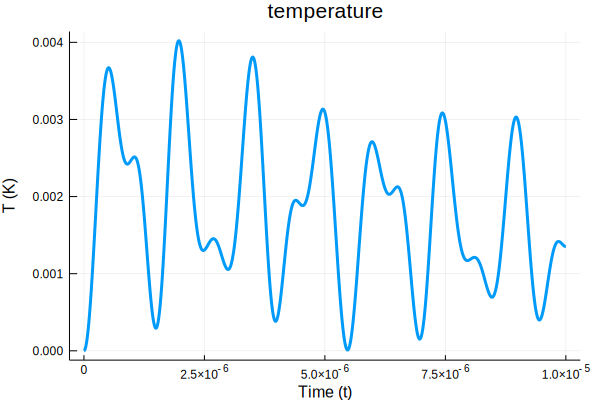

In [71]:
plot(linspace(0,stop,1000), temp, linewidth=3,title="temperature",
     xaxis="Time (t)",yaxis="T (K)", legend=false)

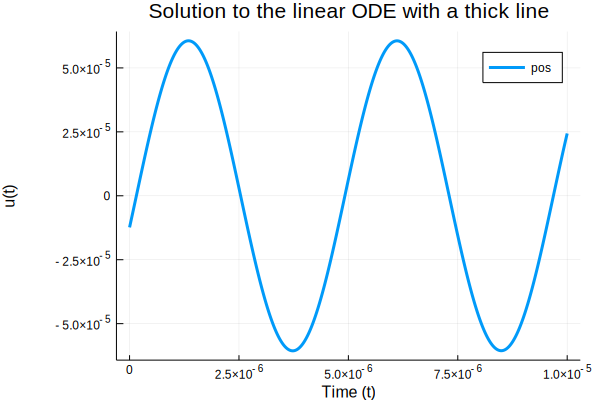

In [89]:
plot(sol.t, [x[3,1,2] for x in sol.u],linewidth=3,title="Solution to the linear ODE with a thick line",
     xaxis="Time (t)",yaxis="u(t)",label="pos") # legend=false

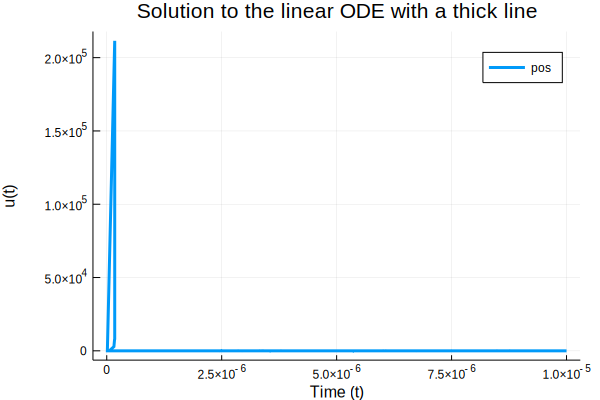

In [119]:
plot(time, temp,linewidth=3,title="Solution to the linear ODE with a thick line",
     xaxis="Time (t)",yaxis="u(t)",label="pos") # legend=false
#plot!(t, [x[1,1,1] for x in sol(t)],linewidth=3,title="Solution to the linear ODE with a thick line",
#     xaxis="Time (t)",yaxis="u(t) (in μm)",label="vel")